# Cluster analysis of parcel trajectory

In [115]:
import numpy as np
import xarray as xr
import glob
import datetime
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import similaritymeasures
import pandas as pd
from rdp import rdp
from sklearn.cluster import DBSCAN
from multiprocessing import Pool

In [116]:
# The data source is from the QCed trajectory files in scratch
# please change 'takaito' to your username
srcdir='/global/cscratch1/sd/takaito/particle_results'

In [117]:
# build a list of available data
! ls /global/cscratch1/sd/takaito/particle_results/StnP*_QC.nc > dataset.txt
f=open('dataset.txt')
fn=f.read().splitlines()

### define some helper functions

In [158]:
def lonlat2meters(data,reflon,reflat,scale):
    Nt=np.size(data[:,0])
    output=np.empty((Nt,2))
    Re=6.37e6
    lon=data[:,0]-reflon
    lat=data[:,1]-reflat
    x=np.cos(reflat*3.14/180)*(Re*3.14/180)*lon
    y=(Re*3.14/180)*lat
    output[:,0]=x*scale
    output[:,1]=y*scale
    return output
    
def calc_df_area(file, eps):
    print('processing '+file)
    ds=xr.open_dataset(file)
    Nptl=np.size((ds['particleID']))
    dtw=np.zeros((Nptl,Nptl))
    df=np.zeros((Nptl,Nptl))
    area=np.zeros((Nptl,Nptl))
    Nt=np.size(ds['time'])
    # Select two trajectories
    for i in range(0,Nptl-1):
        # get particle (i)
        part1data=np.empty((Nt,2))
        part1data[:,0]=ds['lonParticle'][:,i]
        part1data[:,1]=ds['latParticle'][:,i]
        part1=lonlat2meters(part1data,200,50,1e-5)
        # reduce the number of points by RDP algorithm
        part1reduced=rdp(part1,epsilon=eps)
        for j in range(i+1,Nptl):
            # get particle (j)
            part2data=np.empty((Nt,2))
            part2data[:,0]=ds['lonParticle'][:,j]
            part2data[:,1]=ds['latParticle'][:,j]
            part2=lonlat2meters(part2data,200,50,1e-5)
            # reduce the number of points by RDP algorithm
            part2reduced=rdp(part2,epsilon=eps)
            # 1. quantify the difference between the two curves using
            # Discrete Frechet distance
            df[i,j] = similaritymeasures.frechet_dist(part1reduced, part2reduced)
            # 2. quantify the difference between the two curves using
            # area between two curves
            area[i,j] = similaritymeasures.area_between_two_curves(part1reduced, part2reduced)
            # 3. quantify the difference between the two curves using
            # Dynamic Time Warping distance
            dtw[i,j], d = similaritymeasures.dtw(part1reduced, part2reduced)
            # fill lower triangle
            df[j,i]=df[i,j]
            area[j,i]=area[i,j]
            dtw[j,i]=area[i,j]
    return df, area, dtw

### Similarities of trajectory pairs are calculated using three algorithms, and stored in three matrices, df, area and dtw

In [159]:
%%time
df, area, dtw = calc_df_area(fn[0], 1.0)

processing /global/cscratch1/sd/takaito/particle_results/StnP_0-100m_1992-12_QC.nc
CPU times: user 6min 20s, sys: 2.82 s, total: 6min 22s
Wall time: 6min 24s


### Now apply clustering algorithm based on the difference area between two trajectories

CPU times: user 27.1 ms, sys: 700 µs, total: 27.8 ms
Wall time: 25.5 ms


array([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 3, 4, 0, 5, 1, 0, 1,
       1, 1, 0, 1])

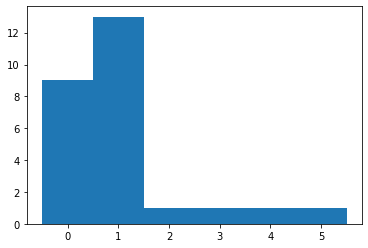

In [191]:
%%time
cl = DBSCAN(eps=700, min_samples=1, metric='precomputed')
cl.fit(area)
cluster=cl.labels_
bins=np.arange(0,np.max(cluster)+2,1)-0.5
plt.hist(cluster,bins)
cluster

### Visualize trajectory clusters using dynamic time warping distance

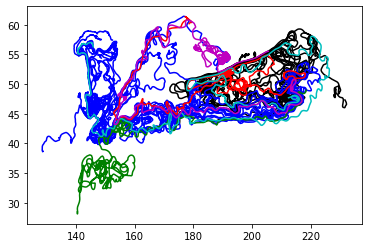

In [192]:
Nc=np.max(cluster)+1
mrk=['k-','b-','r-','g-','c-','m-']
lab=['CL1','CL2','CL3','CL4','CL5','CL6']
for c in range(0,Nc):
    ind=(cluster==c)
    x0=ds['lonParticle']
    y0=ds['latParticle']
    x1=x0[:,ind]
    y1=y0[:,ind]
    plt.plot(x1,y1,mrk[c])
plt.show()

CPU times: user 25.8 ms, sys: 0 ns, total: 25.8 ms
Wall time: 23.8 ms


array([0, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 4, 0, 2, 1, 0, 1,
       1, 1, 0, 1])

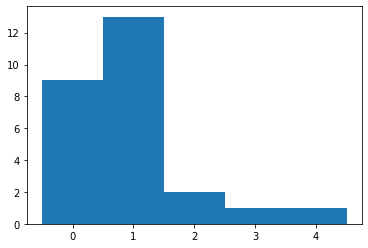

In [193]:
%%time
cl = DBSCAN(eps=300, min_samples=1, metric='precomputed')
cl.fit(dtw)
cluster=cl.labels_
bins=np.arange(0,np.max(cluster)+2,1)-0.5
plt.hist(cluster,bins)
cluster

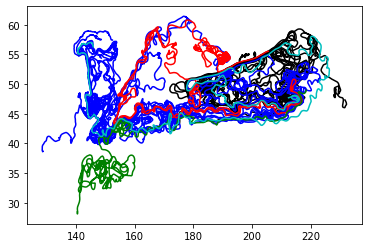

In [194]:
Nc=np.max(cluster)+1
mrk=['k-','b-','r-','g-','c-','m-']
for c in range(0,Nc):
    ind=(cluster==c)
    x0=ds['lonParticle']
    y0=ds['latParticle']
    x1=x0[:,ind]
    y1=y0[:,ind]
    plt.plot(x1,y1,mrk[c])
plt.show()